MonthlyPymt Amortized=$3265.35023077788 | PV=$500000 | Rate=4.875% | Years=20.0 | Interest=$246635.7586274041


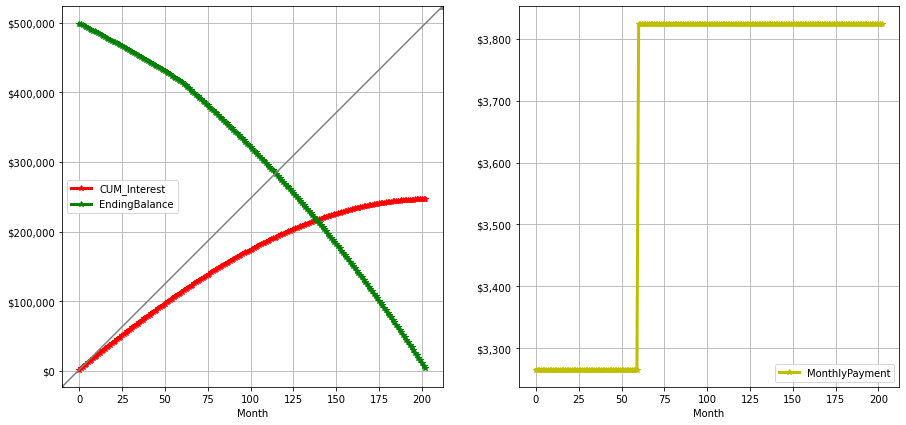

In [6]:
import pandas as pd
import numpy as np
import os
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf
from sympy.solvers import solve  #2022-03-28 07:25:52
from sympy import Symbol

pd.set_option('display.max_rows', None)  #this prints out all rows of data
pd.set_option('display.max_columns', None)
'''
numpy_financial.fv(rate, nper, pmt, pv, when='end')
less than 1hr on this from scratch 2022-05-22 11:35:09 
then 2022-05-23 09:06:52 fine tuned the plot, etc.
next step would be to add a variable payment. so create a column for payment and use at.
'''
x = Symbol('x')
rate = .04875
monthly_rate = rate/12
months = 240
pv = 500_000
expr = npf.fv(rate / 12, months, x, -pv, when='end')
sol = solve(expr)
monthly_payment = sol[0:1]
rate_text = str(np.round_(rate * 100, decimals=4)) 
#############################
df = pd.DataFrame()
num_rows = months
df['Number'] = range(0, num_rows)
monthlypymt = monthly_payment[0]  #sol #this does return the number without list brackets
df.at[0, 'BeginningBalance'] = pv
##############################################variable payments here.
month_to_adjustpayment = 60
monthly_payment_adjusted_amount = 3_825 #monthlypymt

for m in range(0, month_to_adjustpayment):
    df.at[m, 'MonthlyPayment'] = monthlypymt
for m in range(month_to_adjustpayment, num_rows):
    df.at[m, 'MonthlyPayment'] = monthly_payment_adjusted_amount 
####################################################
def ending_beginning_with_npf():
    for j in range(0, num_rows):
        df.at[(j), 'EndingBalance'] = npf.fv(rate=rate / 12,
                                         nper=1,
                                         pmt=df.at[j, 'MonthlyPayment'], #tricky ricky....
                                         pv=-df['BeginningBalance'][j],
                                         when='end')
        df.at[(j + 1), 'BeginningBalance'] = df.at[(j), 'EndingBalance']

def ending_beginning_without_npf():
    for j in range(0, num_rows):
        df.at[(j), 'EndingBalance'] = df.at[(j), 'BeginningBalance']*(1+monthly_rate)-df.at[(j), 'MonthlyPayment']
        df.at[(j + 1), 'BeginningBalance'] = df.at[(j), 'EndingBalance']

#ending_beginning_with_npf()  #choice one
ending_beginning_without_npf() #choice two                                           
df['PrincipalReduction'] = df['BeginningBalance'] - df['EndingBalance']
df['Interest'] = df['MonthlyPayment'] - df['PrincipalReduction']
df['CUM_Interest'] = df['Interest'].cumsum()
df = df.iloc[:, ].fillna(0)
df = df.iloc[:-1]  #drop last row
df['NegativeBalance_BOOLEAN'] = np.where(df['EndingBalance']<=0,0,1)
df = df.astype(float) #create objects to float to plot if df used in a plot
pd.options.display.float_format = "{:,.0f}".format
#display('df', df)
#df.info()

##############to a new df for when when balance is greater than 0.
df_revised = pd.DataFrame()
df_revised['EndingBalance'] = np.where(df.NegativeBalance_BOOLEAN>0,df['EndingBalance'],0)
df_revised['MonthlyPayment'] = np.where(df.NegativeBalance_BOOLEAN>0,df['MonthlyPayment'],0)
df_revised['Interest'] = np.where(df.NegativeBalance_BOOLEAN>=1,df['Interest'],0)
#continue cum and total interest in df through end of amortization period
df_revised['CUM_Interest'] = df_revised['Interest'].cumsum()
df_revised['TOTAL_Interest'] = df_revised['Interest'].sum()
#stop cum and total interest df at end of payoff
#df_revised['CUM_Interest'] = np.where(df.NegativeBalance_BOOLEAN>=1,df_revised['Interest'].cumsum(),0)
#df_revised['TOTAL_Interest'] = np.where(df.NegativeBalance_BOOLEAN>=1,df_revised['Interest'].sum().cumsum(),0)
df_revised['Interest_is_ZERO_col_BOOLEAN'] = np.where(df_revised['Interest']==0,1,0)
df_revised['Number_MonthsEarly_Payoff'] = df_revised['Interest_is_ZERO_col_BOOLEAN'].sum()
#########.................
SCALAR_INTEREST = df_revised['TOTAL_Interest'].iloc[:1] #first row
SCALAR_MonthsPayoff = df_revised['Number_MonthsEarly_Payoff'].iloc[0:1] #first row
if SCALAR_MonthsPayoff[0] == 0:
    SCALAR_MonthsPayoff[0]=1  
df_revised = df_revised.astype(float) #create objects to float to plot
df_revised = df_revised.iloc[:-SCALAR_MonthsPayoff[0]]  #drop last rows 
pd.options.display.float_format = "{:,.0f}".format
#display('df_revised', df_revised)
#######################plot.....................................
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7)) #width, height
df_revised['CUM_Interest'].plot(kind='line',
                        grid=True,
                        legend=True,
                        marker='*',
                        color='r',
                        linewidth=3,
                               ax=ax1)  #added more 3/1

df_revised['EndingBalance'].plot(kind='line',
                        grid=True,
                        legend=True,
                        marker='*',
                        color='g',
                        linewidth=3,
                                ax=ax1)  #added more 3/1
df_revised['MonthlyPayment'].plot(kind='line',
                        grid=True,
                        legend=True,
                        marker='*',
                        color='y',
                        linewidth=3,
                                 ax=ax2)  #added more 3/1
ax1.plot([0, 1], [0, 1], color='gray', marker='^', transform=ax1.transAxes)
ax1.yaxis.set_major_formatter('${x:,.0f}')
ax2.yaxis.set_major_formatter('${x:,.0f}')
ax1.set_xlabel('Month', fontsize=10)
ax2.set_xlabel('Month', fontsize=10)

print(f'MonthlyPymt Amortized=${monthlypymt} | PV=${pv} | Rate={rate_text}% | Years={months/12} | Interest=${SCALAR_INTEREST[0]}')


